<a href="https://colab.research.google.com/github/Evergarden0101/FS23-Deep-Learning/blob/main/DL_Assignment06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 6: Convolutional Networks

Before we start, we should assure that we have activated CUDA -- otherwise training might take very long.
In Google Colaboratory:

1. Check the options Runtime -> Change Runtime Type on top of the page.
2. In the popup window, select hardware accelerator GPU.

Afterward, the following command should run successfully:

In [ ]:
import torch
if torch.cuda.is_available():
  print("Successfully enabled CUDA processing")
else:
  print("CUDA processing not available. Things will be slow :-(")

Successfully enabled CUDA processing


## Dataset

In PyTorch, a dataset stores a list of input and target tensors $(X^n, T^n)$.
In case of **MNIST** dataset, the inputs are $X^n \in \mathbb R^{28\times28}$ and $T^n \in \{0,\ldots,9\}$.
More precisely, the data in the dataset is provided in form of `PIL.Image.Image`, which represents an image class with some more functionality, and pixel values in range $[0, 255]$.
In order to convert these images into `torch.Tensor`'s in range $[0,1]$, we can use the [ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html) transform.
Furthermore, in `PyTorch` batches are created from datasets using the [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) class.


### Task 1: Dataset Loading


Here, we use the [MNIST dataset](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html) of gray images for categorical classification.

Write a function that returns the training and the testing set of MNIST, using the given transform.

In [ ]:
import torch
import torchvision

def datasets(transform):
  trainset = torchvision.datasets.MNIST(
    root="./MNISTdata",
    train=True,
    transform=transform,
    download=True)

  testset = torchvision.datasets.MNIST(
    root="./MNISTdata",
    train=False,
    transform=transform,
    download=True)

  return trainset, testset

### Test 1: Data Types

When we create the dataset with `transform=None`, all inputs shall be of type `PIL.Image.Image`, and all targets are integral.

In [ ]:
import PIL
trainset, testset = datasets(transform=None)

for x,t in trainset:
  # check datatype of input x
  assert isinstance(x, PIL.Image.Image)
  # check datatype of target t
  assert isinstance(t, int)

100%|██████████| 9912422/9912422 [00:00<00:00, 131617021.58it/s]

Extracting ./MNISTdata/MNIST/raw/train-images-idx3-ubyte.gz to ./MNISTdata/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 102657367.65it/s]


Extracting ./MNISTdata/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNISTdata/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 134726031.92it/s]

Extracting ./MNISTdata/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNISTdata/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 1542677.85it/s]


Extracting ./MNISTdata/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNISTdata/MNIST/raw



### Task 2: Data Loaders


Create the dataset with transform `ToTensor`. Create two data loaders, one for the training set and one for the testing set. The training batch size should be $B=64$, for the testing set, you can select any batch size of your choice.


In [ ]:
transform = torchvision.transforms.ToTensor()
trainset, testset = datasets(transform=transform)

B = 64
trainloader = torch.utils.data.DataLoader(trainset, batch_size=B, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

### Test 2: Batches

Check that all batches generated by the training set data loader have the batch size of $B$ -- except for the last batch, which you need to compute by yourself (you might want to make use of the modulo operator `%`).

Afterward, we check that all inputs and targets are of type `torch.Tensor`, that all input values are in range $[0,1]$ and that all target values are in range $[0,9]$.

In [ ]:
# compute the size of last batch
last_batch = len(trainset)%B

for x,t in trainloader:
  # check datatype, size and content of x
  assert isinstance(x, torch.Tensor)
  assert(torch.all(x >= 0)) and torch.all(x <= 1)  
  assert len(x)==B or len(x) == last_batch

  # check datatype, size and content of t
  assert isinstance(t, torch.Tensor)
  assert(torch.all(t >= 0)) and torch.all(t <= 9)
  assert len(t)==B or len(t) == last_batch

## Networks
As last week, we will rely on [Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) to create networks with particular lists of consecutive layers.
Particularly, we will investigate two different versions of networks, one fully-connected network and one convolutional network, with the same number of learnable layers.

### Task 3: Fully-Connected Network


Implement a function that returns a three-layer fully-connected network in `pytorch`.
Use $\tanh$ as activation function between the two fully-connected layers, and provide the possibility to change the number of inputs $D$, the number of hidden neurons $K$ and the number of outputs $O$.
Use the following layers:

1. A [Flatten layer](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) to turn the $28\times28$ pixel image (2D) into a $28\cdot28$ pixel vector (1D).
2. A [fully-connected layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) with D input neurons and K outputs.
3. A [$\tanh$ activation function](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html).
4. A fully-connected layer with K input neurons and K outputs.
5. A $\tanh$ activation function.
6. A fully-connected layer with K input neurons and O outputs.

In [ ]:
def fully_connected(D, K, O):
  return torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(D, K),
    torch.nn.Tanh(),
    torch.nn.Linear(K, K),
    torch.nn.Tanh(),
    torch.nn.Linear(K, O)
  )

### Task 4: Convolutions Output (theoretical question)

Consider the network as defined in Task 5.
Assume that the input is a $28\times28$ grayscale image.
How many hidden neurons do we need in the final fully-connected layer for a given number $Q_2$ of output channels of the second convolution?

...

Answer: $Q_2\times7\times7$

### Task 5: Convolutional Network

Implement a function that generates a convolutional network with the following layers:

1. A [2D convolutional layer](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) with $Q_1$ channels, kernel size $5\times5$, stride 1 and padding 2.
2. A [2D maximum pooling](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) with pooling size $2\times2$ and stride 2.
3. A $\tanh$ activation function.
4. A 2D convolutional layer with $Q_2$ channels, kernel size $5\times5$, stride 1 and padding 2.
5. A 2D maximum pooling with pooling size $2\times2$ and stride 2.
6. A $\tanh$ activation function.
7. A flattening layer to turn the 3D feature map into a 1D vector.
8. A fully-connected layer with the appropriate number of inputs and $O$ outputs.

In [ ]:
def convolutional(Q1, Q2, O):
  return torch.nn.Sequential(
    torch.nn.Conv2d(1, Q1, (5,5), stride=1, padding=2),
    torch.nn.MaxPool2d((2,2), stride=2),
    torch.nn.Tanh(),
    torch.nn.Conv2d(Q1, Q2, (5,5), stride=1, padding=2),
    torch.nn.MaxPool2d((2,2), stride=2),
    torch.nn.Tanh(),
    torch.nn.Flatten(),
    torch.nn.Linear(Q2*7*7, O)
  )

## Network Training
For training and evaluating the network, we rely on standard functionality in PyTorch.
We use the standard [categorical cross-entropy loss](https://pytorch.org/docs/stable/nn.html#loss-functions) together with a [stochastic gradient descent](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) optimizer.
For training, we use the batched implementation of the dataset, for which we perform one update step for each training batch.
After having gone through the full training dataset, we compute accuracy and loss values for the testing set (we simply make use of the testing set for validation).


### Task 6: Training and Validation Loop

Implement a function that takes the network, the number of epochs, and the learning rate.
Select the correct loss function for categorical classification and SGD optimizer.
Iterate the following steps for the given number of epochs:

1. Train the network with all batches of the training data.
2. Compute the testing set loss and testing set accuracy.
3. Store both in a vector.

What do we need to take care of?

Finally, return the lists of validation losses and accuracies.

In [ ]:
def train(network, epochs, eta, momentum):
  # select loss function and optimizer
  loss = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(network.parameters(), lr=0.02, momentum=momentum)

  # instantiate the correct device
  device = torch.device("cuda")
  network = network.to(device)

  # collect loss values and accuracies over the training epochs
  val_loss, val_acc = [], []

  for epoch in range(epochs):
    # train network on training data
    for x,t in trainloader:
      # put data to device
      x = x.to("cuda")
      t = t.to("cuda")
      # train
      optimizer.zero_grad()
      output = network(x)
      train_loss = loss(output, t)
      train_loss.backward()
      optimizer.step()

    # test network on test data
    with torch.no_grad():
      val_loss_value = 0 # add by myself
      correct = 0 # add by myself
      for x,t in testloader:
        # put data to device
        x = x.to("cuda")
        t = t.to("cuda")
        # compute validation loss
        output = network(x)
        val_loss_value += loss(output, t).item()
        # compute validation accuracy
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(t.data.view_as(pred)).sum().item()
    val_loss_value /= len(testloader.dataset)
    val_acc_value = correct / len(testloader.dataset)
    val_loss.append(val_loss_value)
    val_acc.append(val_acc_value)
    print('Train Epoch: {}\tLoss: {:.6f}\tAccuracy: {:.6f}'.format(
        epoch+1, val_loss_value, val_acc_value))

  # return loss and accuracy values
  return val_loss, val_acc

### Task 7: Fully-Connected Training

Create a fully-connected network with $K=100$ hidden and $O=10$ output neurons.
Train the network for 10 epochs with $\eta=0.01$, $momentum=0.9$ and store the obtained test losses and accuracies.
Brave people can also train for 100 epochs (which will take up to 30 minutes).

In [ ]:
fc = fully_connected(28*28, 100, 10)
fc_loss, fc_acc = train(fc, 10, 0.01, 0.9)

Train Epoch: 1	Loss: 0.005964	Accuracy: 0.944300
Train Epoch: 2	Loss: 0.004172	Accuracy: 0.959100
Train Epoch: 3	Loss: 0.003304	Accuracy: 0.966400
Train Epoch: 4	Loss: 0.002911	Accuracy: 0.969100
Train Epoch: 5	Loss: 0.002838	Accuracy: 0.971600
Train Epoch: 6	Loss: 0.002548	Accuracy: 0.973800
Train Epoch: 7	Loss: 0.002690	Accuracy: 0.974500
Train Epoch: 8	Loss: 0.002389	Accuracy: 0.974900
Train Epoch: 9	Loss: 0.002586	Accuracy: 0.975000
Train Epoch: 10	Loss: 0.002227	Accuracy: 0.978400


### Task 8: Convolutional Training


Create a convolutional network with $Q_1=16$ and $Q_2=32$ convolutional channels and $O=10$ output neurons.
Train the network for 10 epochs with $\eta=0.01$, momentum $=0.9$ and store the obtained test losses and accuracies.
Again, 100 epochs will take up to 30 minutes.

In [ ]:
cv = convolutional(16, 32, 10)
cv_loss, cv_acc = train(cv, 10, 0.01, 0.9)

Train Epoch: 1	Loss: 0.001803	Accuracy: 0.981100
Train Epoch: 2	Loss: 0.001155	Accuracy: 0.987400
Train Epoch: 3	Loss: 0.001067	Accuracy: 0.988100
Train Epoch: 4	Loss: 0.001117	Accuracy: 0.988500
Train Epoch: 5	Loss: 0.001085	Accuracy: 0.987900
Train Epoch: 6	Loss: 0.000980	Accuracy: 0.989700
Train Epoch: 7	Loss: 0.000825	Accuracy: 0.991100
Train Epoch: 8	Loss: 0.000908	Accuracy: 0.990700
Train Epoch: 9	Loss: 0.000876	Accuracy: 0.990700
Train Epoch: 10	Loss: 0.000867	Accuracy: 0.991000


### Task 9: Plotting

Plot the two lists of loss values in one plot. Plot the two lists of accuracy values into another plot.

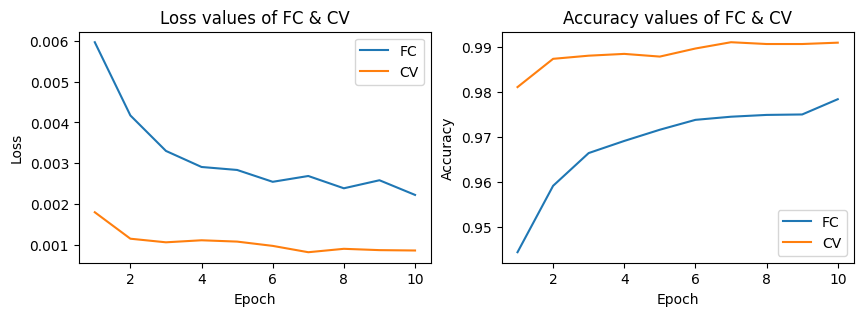

In [ ]:
from matplotlib import pyplot
pyplot.figure(figsize=(10,3))
ax = pyplot.subplot(121)
# plot loss values of FC and CV network over epochs
x = [1,2,3,4,5,6,7,8,9,10]
pyplot.plot(x, fc_loss, label='FC')
pyplot.plot(x, cv_loss, label='CV')
pyplot.xlabel("Epoch")
pyplot.ylabel("Loss")
pyplot.title("Loss values of FC & CV")
pyplot.legend()
ax = pyplot.subplot(122)
# plot accuracy values of FC and CV network over epochs
pyplot.plot(x, fc_acc, label='FC')
pyplot.plot(x, cv_acc, label='CV')
pyplot.xlabel("Epoch")
pyplot.ylabel("Accuracy")
pyplot.title("Accuracy values of FC & CV")
pyplot.legend()
pyplot.show()

### Task 10: Learnable Parameters 

Estimate roughly how many learnable parameters the two networks have by analytically computing and adding the number of parameters in each layer.

Fully-connected Network:
- first fully-connected layer: 78500
- second fully-connected layer: 10100
- third fully-connected layer: 1010
- total: 89610

Convolutional Network:
- first convolutional layer: 416
- second convolutional layer: 12832
- fully-connected layer: 15690
- total: 28938



Now, compute the number of parameters in the networks by summing the number of parameters in each layer using `pytorch` functionality.
You can use the `numel()` function from a `torch.Tensor` to provide the number of (learnable) parameters stored in a tensor.
How do you obtain this list of all learnable parameters from a `pytorch` [Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)?

In [ ]:
def parameter_count(network):
  num_params = 0
  for p in network.parameters():
        num_params += p.numel()
  return num_params

print("Fully-connected Network:", parameter_count(fc))
print("Convolutional Network:", parameter_count(cv))

Fully-connected Network: 89610
Convolutional Network: 28938
